    fluxmode:
      High Flux (HF)    = 9.0 deg
      Intermidiste (AI) = 4.4 deg
      High Res (HR)     = 2.0 deg
    Frequency DoubleDisk Chopper 1: (Hz)         300 Hz for HF       240 Hz for AI        180 Hz for HR
    Frequency DoubleDisk Chopper 2: (Hz)         300 Hz for HF       240 Hz for AI        180 Hz for HR


In [1]:
workdir = '~/dv/sns-chops/resolution/CNCS/mcvine'
!mkdir -p {workdir}
%cd {workdir}

/SNS/users/lj7/dv/sns-chops/resolution/CNCS/mcvine


In [2]:
import numpy as np, os, sys, glob
from matplotlib import pyplot as plt

import histogram.hdf as hh, histogram as H
import mcvine, mcvine.components
from mcni.utils import conversion as C

from matplotlib import pyplot as plt
%matplotlib notebook

import mcvine, mcvine.components as mcomps
from mcvine import run_script

from mantid import simpleapi as msa

/SNS/software/miniconda2/envs/spida/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/SNS/software/miniconda2/envs/spida/lib/python2.7/site-packages/mantid/kernel/__init__.py:23: RuntimeWarning: to-Python converter for std::vector<int, std::allocator<int> > already registered; second conversion method ignored.
  from ._kernel import *
/SNS/software/miniconda2/envs/spida/lib/python2.7/site-packages/mantid/kernel/__init__.py:23: RuntimeWarning: to-Python converter for std::vector<double, std::allocator<double> > already registered; second conversion method ignored.
  from ._kernel import *


# Instrument sim script

# Ei=20meV high resolution

In [3]:
beamdir = os.path.abspath("Ei_20meV_InterpMod_MoreCounts/beam-Ei_20-fluxmode_2.0/")
#!rm -rf {beamdir}
!mkdir -p {beamdir}

In [4]:
%%time
run_script.run_mpi(
    './CNCS_Dec_2016_py_mcvine.py', 
    '%s/_m2sout' % beamdir,
    ncount=1e9, nodes=20,
    Ei=20, Erange_fraction=0.04,
    fluxmode=2.0, f41=180., f42=180.,
    analytical_moderator=False
)

CPU times: user 3.26 ms, sys: 55 ms, total: 58.3 ms
Wall time: 40min 16s


Run postprocessing so that this works with other apps such as resolution calculation

In [5]:
from mcvine.instruments.CNCS import beam_postprocessing as bpp

In [6]:
bpp.run(
    '%s/_m2sout/' % beamdir, 
    '%s/out' % beamdir,
    Ei=20.
)

Running beam monitors...
 -> running mcvine_analyze_beam --output-dir=/SNS/users/lj7/dv/sns-chops/resolution/CNCS/mcvine/Ei_20meV_InterpMod_MoreCounts/beam-Ei_20-fluxmode_2.0/out --ncount=20431 --buffer_size=20431 --geometer.source="((0,0,-0.15),(0,0,0))" --source.path=/SNS/users/lj7/dv/sns-chops/resolution/CNCS/mcvine/Ei_20meV_InterpMod_MoreCounts/beam-Ei_20-fluxmode_2.0/_m2sout/neutrons --monitor.mtof.tofmin=0.016685186977609453 --monitor.mtof.tofmax=0.02039300630596711 --monitor.mtof.ntof=1000 --monitor.menergy.energymin=18.0 --monitor.menergy.energymax=22.0 --monitor.menergy.nenergy=1000...
done.


In [7]:
!mcvine neutronstorage count {beamdir}/out/neutrons

20431


<IPython.core.display.Javascript object>


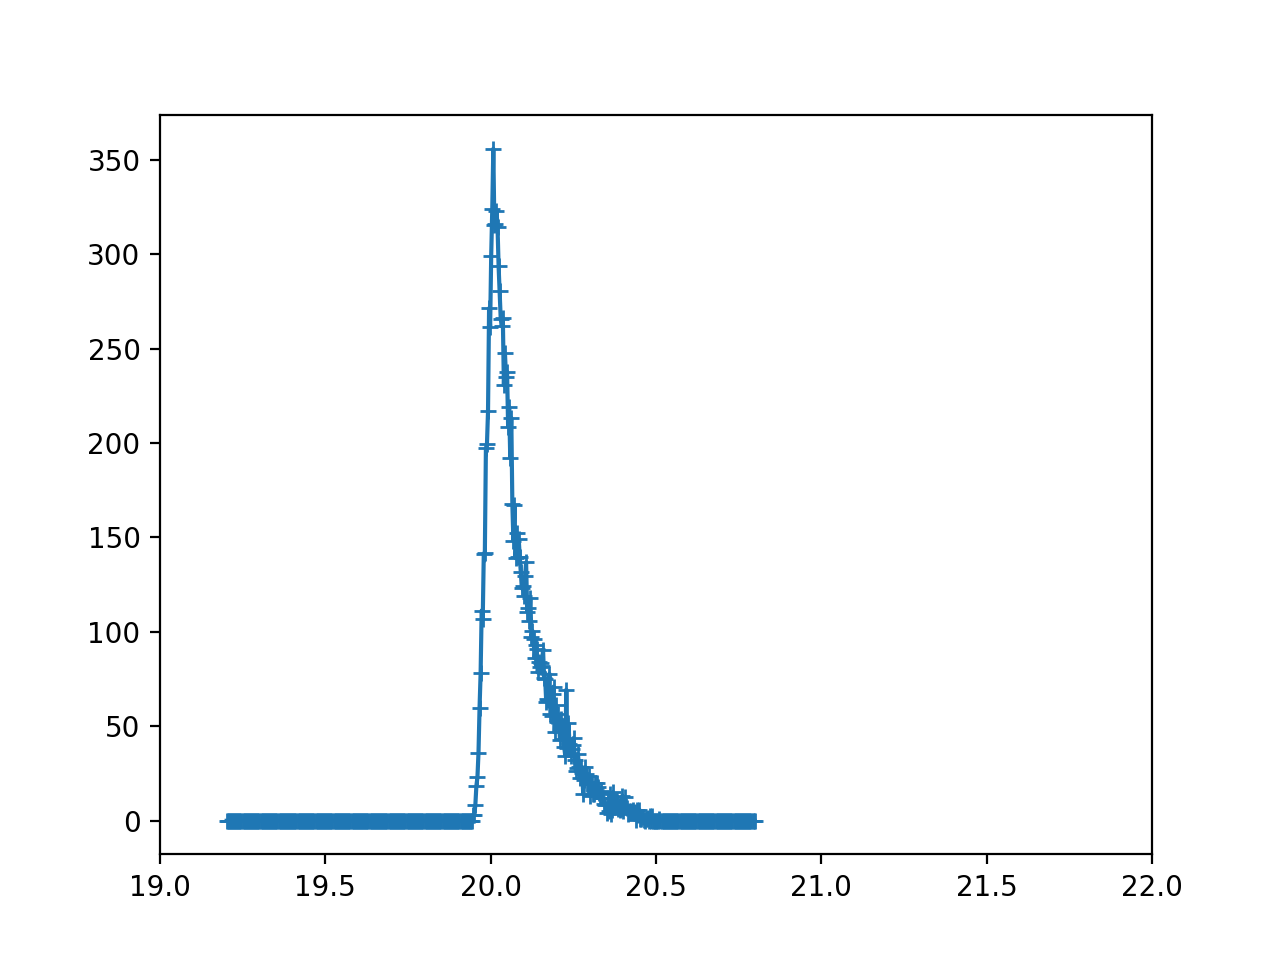

(19, 22)

In [8]:
plt.figure()
IE = hh.load('%s/_m2sout/beam_I_E.h5' % beamdir)
plt.plot(IE.energy, IE.I, '+-')
plt.xlim(19, 22)

<IPython.core.display.Javascript object>


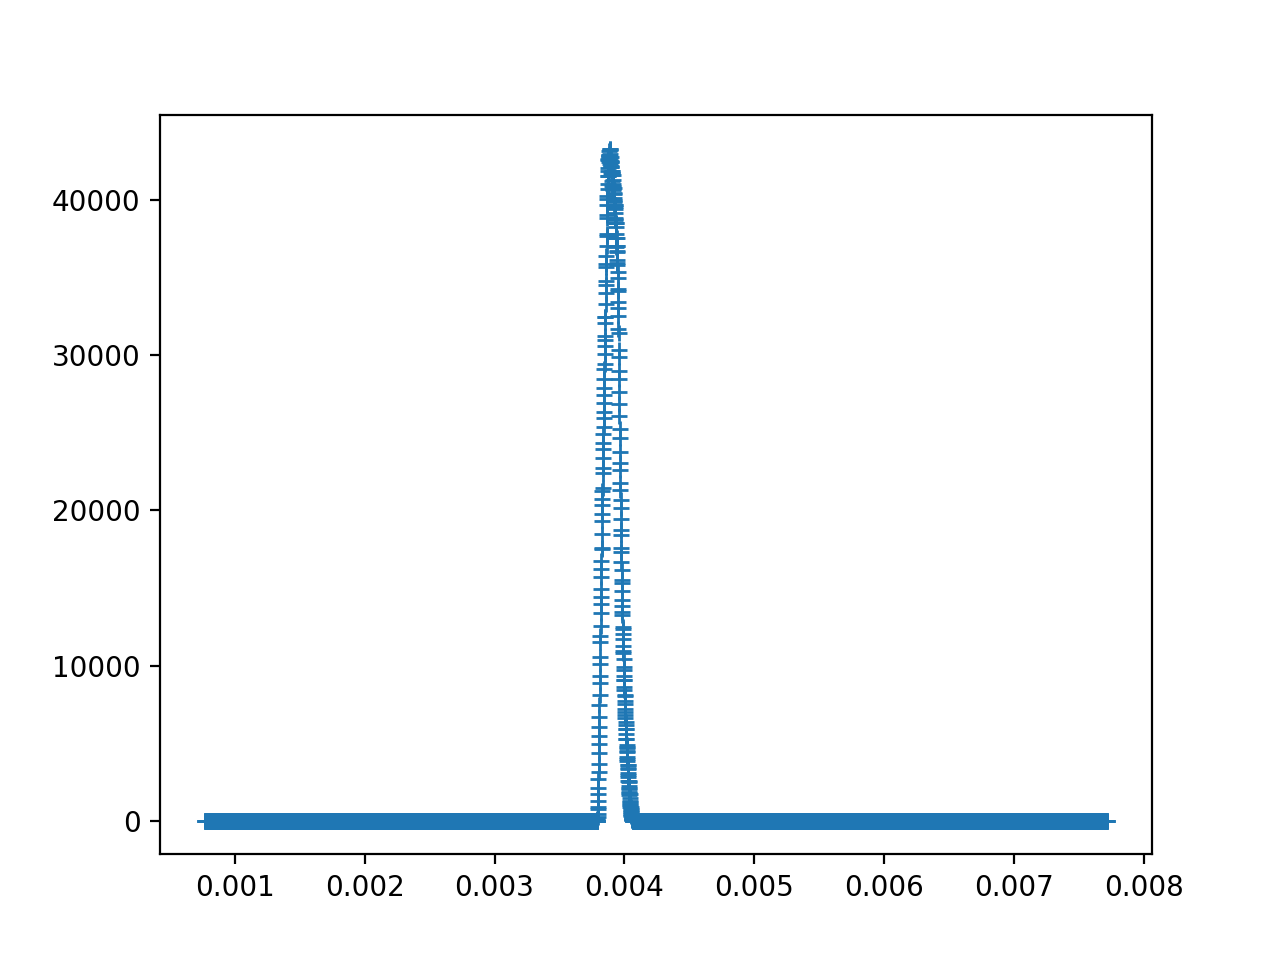

In [9]:
plt.figure()
m2 = hh.load('%s/_m2sout/tof2.h5' % beamdir)
plt.plot(m2.tof, m2.I, '+')
# plt.xlim(0.0165, 0.0179)

<IPython.core.display.Javascript object>


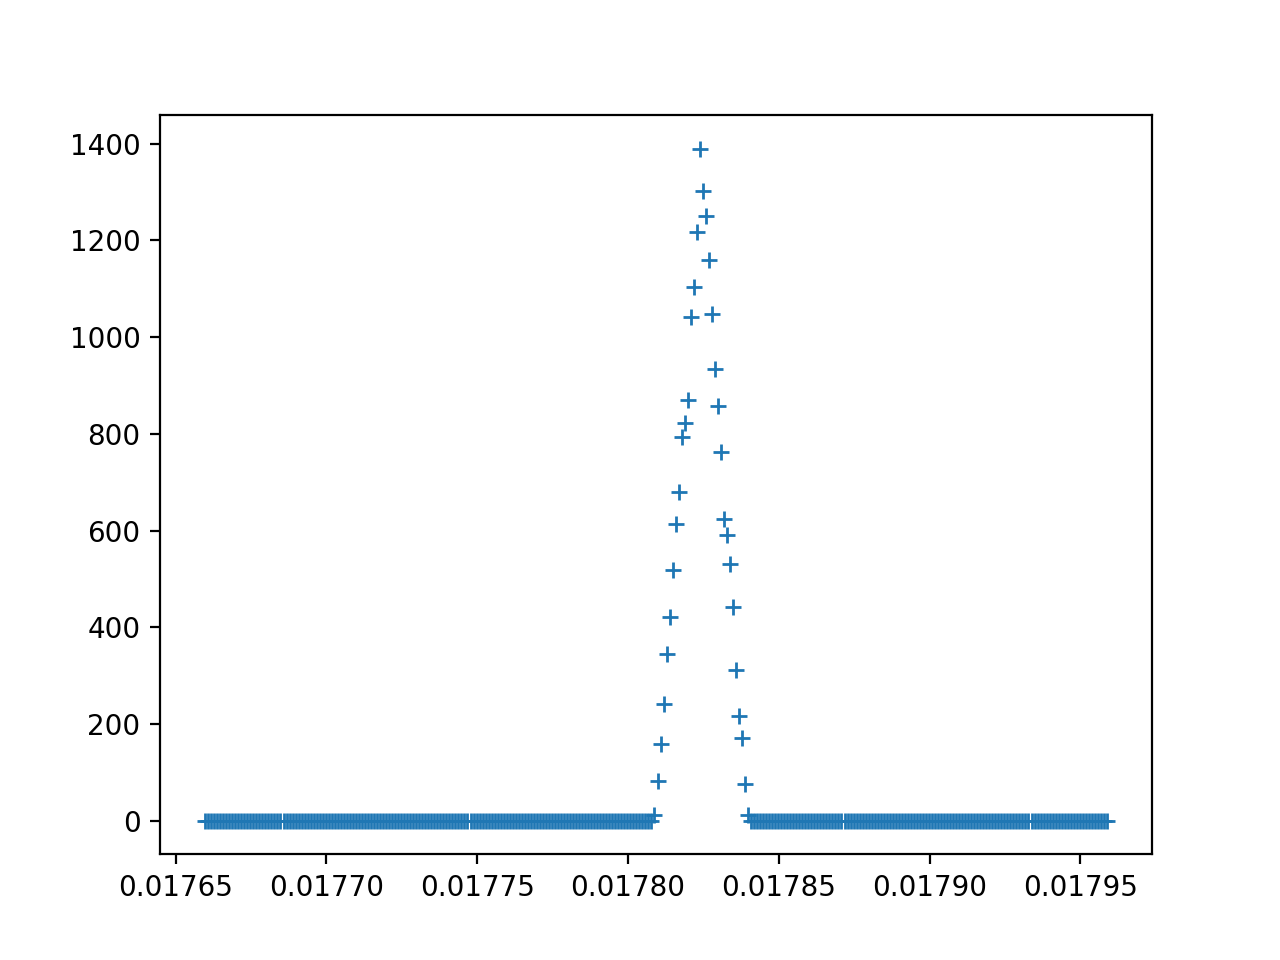

In [10]:
plt.figure()
m3 = hh.load('%s/_m2sout/tof3a.h5' % beamdir)
plt.plot(m3.tof, m3.I, '+')
# plt.xlim(0.0797, 0.0798)

In [11]:
mons = msa.LoadNexusMonitors("/SNS/CNCS/IPTS-20360/nexus/CNCS_274512.nxs.h5")

In [12]:
msa.Rebin(InputWorkspace='mons', OutputWorkspace='mons', Params="%s,%s,%s" % (0, 1., 80000))

EventWorkspace
Title: V-foil HR, T=300 K, Ei=20.43628 meV
Histograms: 2
Bins: 80000
Histogram
X axis: Time-of-flight / microsecond
Y axis: Counts
Distribution: False
Instrument: CNCS (2017-Aug-07 to 2100-Jan-31)Instrument from: /SNS/CNCS/IPTS-20360/nexus/CNCS_274512.nxs.h5

Parameters from: /SNS/users/lj7/.mantid/instrument/CNCS_Parameters.xml
Run start: 2018-Jun-07 23:55:19
Run end:  2018-Jun-08 00:35:09

Events: 26733067

In [13]:
mons.getNumberHistograms()

2

In [14]:
exp_m1 = msa.CropWorkspace(mons, StartWorkspaceIndex = 1, EndWorkspaceIndex = 1)

In [15]:
exp_m0 = msa.CropWorkspace(mons, StartWorkspaceIndex = 0, EndWorkspaceIndex = 0)

<IPython.core.display.Javascript object>


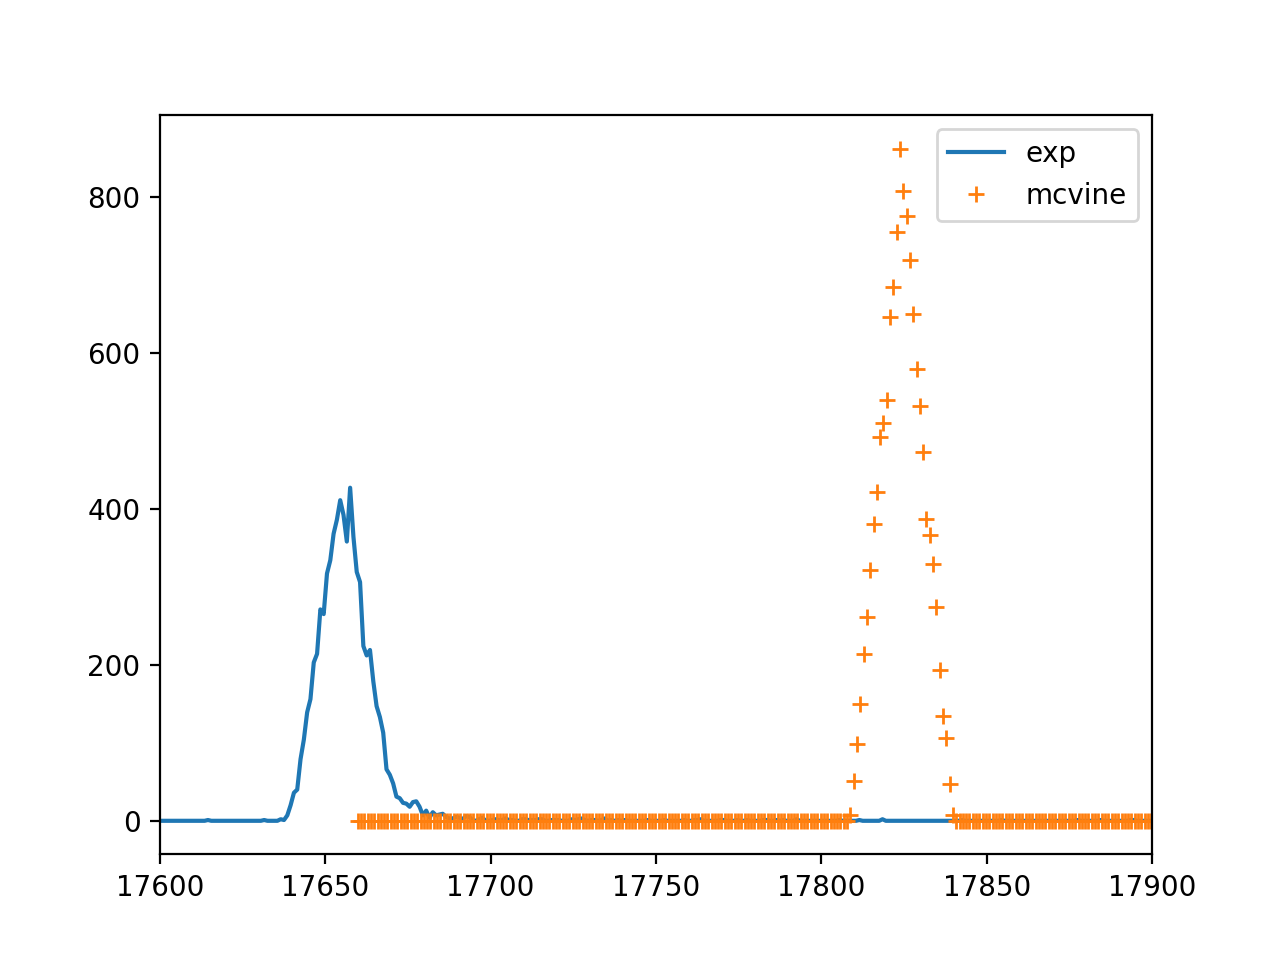

(17600, 17900)

In [16]:
xbb = exp_m1.extractX()[0]
x = (xbb[1:]+xbb[:-1])/2

y = exp_m1.extractY()[0]

plt.figure()
plt.plot(x, y, label='exp')
plt.plot(m3.tof*1e6, m3.I*.62, '+', label='mcvine')
plt.legend()
plt.xlim(17600, 17900)

<IPython.core.display.Javascript object>


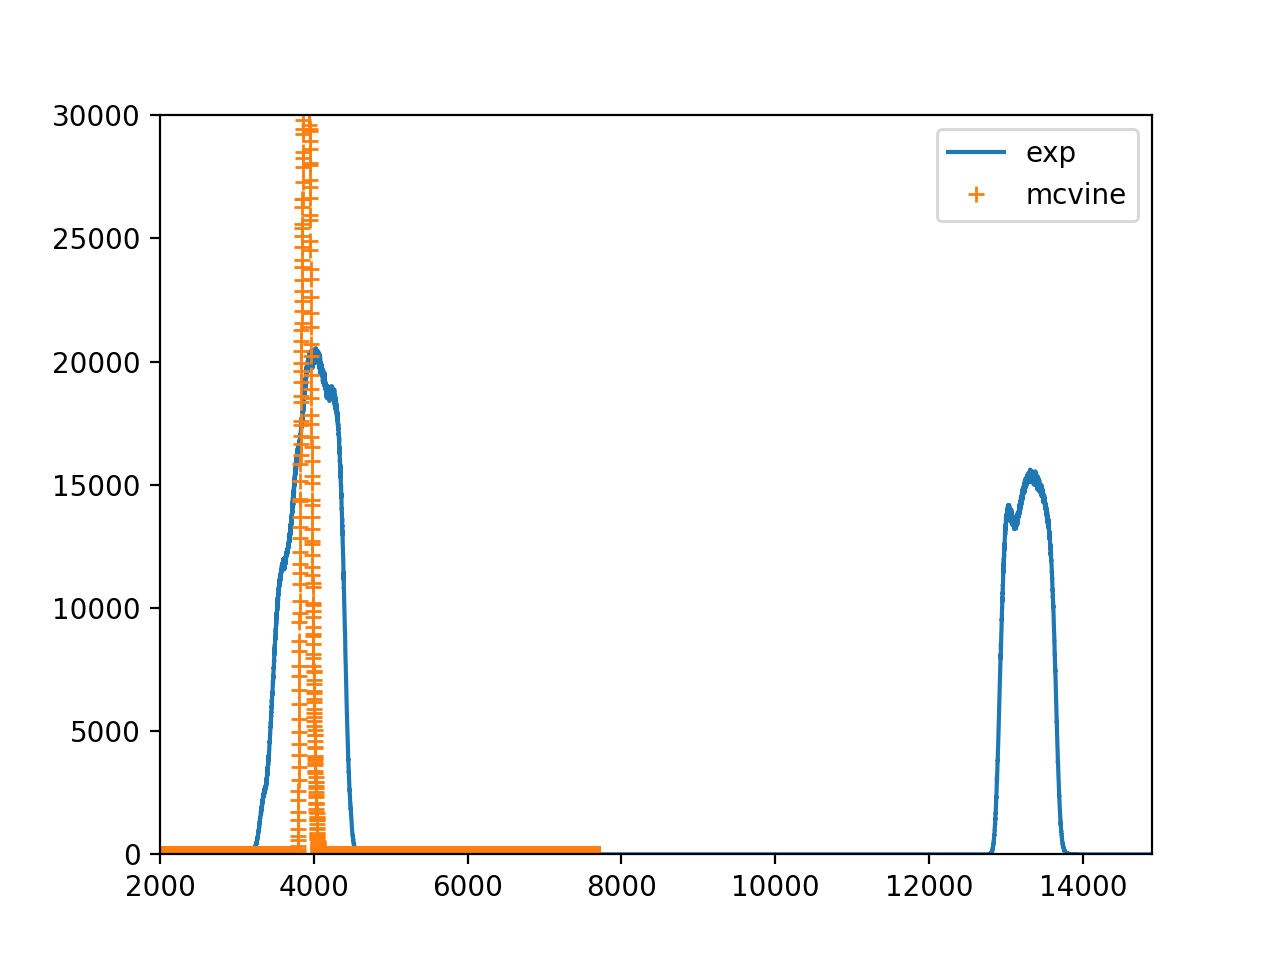

(0, 30000)

In [17]:
xbb = exp_m0.extractX()[0]
x = (xbb[1:]+xbb[:-1])/2

y = exp_m0.extractY()[0]

plt.figure()
plt.plot(x, y, label='exp')
plt.plot(m2.tof*1e6, m2.I*.82, '+', label='mcvine')
plt.legend()
plt.xlim(2000, 14900)
plt.ylim(0, 30000)